  # ASETS-II cases simulation

  This is an example of a simulation package for conjugate heat transfer of an
  oscillating heat pipe. SI units are used and units are emitted

  ### What do we need to solve an OHP problem?

  **specify properties** : Solid property, Fluid property

  **set the geometries** : Computational domain, Heaters/Condensers, OHP shapes

  **construct the systems** : Fluid system(1D), HeatConduction system(2D)

  **initialize** : initialize the integrators and the data structs for saving

  **solve** : time marching to solve the two weakly coupled integrators
  alternately

  **save/examine** : save the data for post-processing

  # Packages

  Firstly, let's import the necessary packages, you may need to install them
  for the first time.

In [4]:
] activate ..

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [5]:
using ComputationalHeatTransfer # our main package
using Plots # for plotting
using ProgressMeter # to have a progress bar in the calculation

In [6]:
using Revise

  # Specify properties

  ### Solid Physical parameters

  params is the HeatConductionParameters for the plate material. The numbers
  below represents aluminum.

In [7]:
ρₛ = 2730; # material density [kg/m^3]
cₛ  = 8.93e02; # material specific heat [J/kg K]
kₛ  = 1.93e02; # material heat conductivity
plate_d = 1.5e-3; # effective d (The thickness of an ideal uniform thickness plate occupying the same volume)
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

  ### Fluid Physical parameters

  pfluid contains the vapor and liquid properties at a constant reference
  temperature. Noted that the vapor pressure and the vapor density will be
  functions of temperatures during the simulation, other properties are
  extracted from pfluid as an approximate value.

In [8]:
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref)

Saturation properties for Butane at constant temperature 291.2 [K]


  # Set the geometries

  ### Geometry parameters

  The 2D domain is of rectangular shape (slightly different from ASETS-II). In
  the future it can be of arbitrary shape using the immersedlayers.jl package.

In [9]:
Lx = 0.1524; # plate size x [m]
Ly = 0.0648; # plate size y [m]
# Ly = 0.0462*1.15; # plate size y [m]
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

(-0.0324, 0.0324)

  ### Set mesh size and maximum time step for plate heat conduction

  Δx is controlled by Δx = α*gridPe and set having the same order of magitute
  of tube diameter 1e-3. Fourier number is used to give a safety "cap" of time
  step you can choose in the fluid module

In [10]:
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0006333345639056725, 0.001520002953373614)

  ### Set up the evaporators and condensers

  Right now, the OHPtype looks up a preset dictionary of OHP evaporators and
  condensers.

  You can also customize them in the OHP DIY notebook

In [11]:
OHPtype = "ASETS-II OHP 1 LARGE HEATER"
power = 40 # total heater power in watts
Tc = Tref; # condenser temperature
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,Δx,hc2ratio=0.07);

  ### Set up OHP channel's shape

  constructohpcurve is a built-in function that generates two arrays: x that
  contains all x values of the discrete points, and y contains all y values. x
  and y have the same length.

  You can also customize this function to generate an OHP shape of your choice
  as long as they produce x array and y array.

In [12]:
x, y = construct_ohp_curve("ASETS",Δx) # get x and y coordinates for the channel
ohp = BasicBody(x,y) # build a BasicBody based on x,y

ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp) # build a line heat source based on BasicBody

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

  ### Plot what you got so far

  This is a exmaple of the compuational domain (the box) and the OHP channel
  serpentine (in blue)

In [13]:
# x2Dsensors = [0.0,0.0] 
# y2Dsensors = [-60e-3,60e-3] 
x2Dsensors = [-2.9,-1.4,-0.8,0.0,0.0,0.8,1.4,2.9] .* inches
y2Dsensors = [0.0,   0.0, 0.0,0.0,0.4,0.0,0.0,0.0] .* inches
plate_sensors = (x2Dsensors,y2Dsensors);
RTD_for_plotting = [4,8];

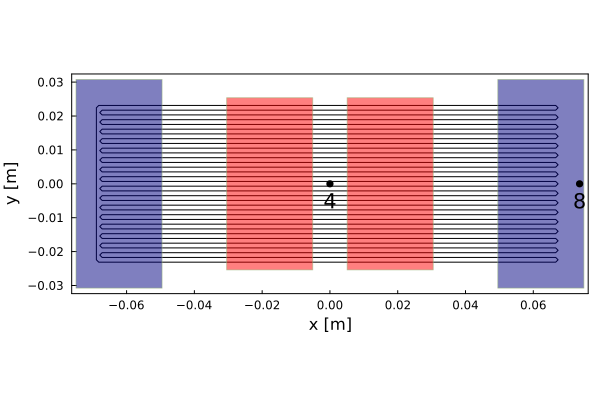

In [14]:
# plot ohp
plt = plot(ohp,fillalpha=0,linecolor=:black,xlims=xlim,ylims=ylim,framestyle = :box,xlabel="x [m]",ylabel="y [m]")

# plot heaters (red)
for ep in eparams
    plot!(ep)
end

# plot condensers (blue)
for cp in [cparams[2]]
    plot!(cp)
end

for cp in [cparams[1]]
    plot!(cp)
end

scatter!(markercolor=:black,x2Dsensors[RTD_for_plotting],y2Dsensors[RTD_for_plotting])
annotate!(x2Dsensors[RTD_for_plotting], y2Dsensors[RTD_for_plotting].-0.005, RTD_for_plotting)

# show plot
plt
# savefig("layout_L1.pdf")

  # Construct the systems

  ### Create HeatConduction system

  The solid module dealing with the 2D conduction, evaporator, condenser, and
  the OHP line heat source is constructed here.

In [21]:
sys_plate = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom,qflux=eparams,qmodel=cparams)

Unbounded Heat conduction system on a grid of size 252 x 108 and 0 static immersed points


  ### Create OHP inner channel system

  sys_tube: fluid module system

In [22]:
sys_tube = initialize_ohpsys(sys_plate,p_fluid,power,ηplus=0.6,nucleatenum = 1000,Rn_boil=3e-6,inertia_f=1.3,ηminus=0.0)

4877 point OHP system filled with Butane


  # Initialize

  ### set time step

In [23]:
tspan = (0.0, 10.0); # start time and end time
dt_record = 1.0   # saving time interval

tstep = 4e-4     # actrual time marching step

0.0004

  ### combine inner tube and plate together

In [24]:
u_plate = newstate(sys_plate) .+ Tref # initialize plate T field to uniform Tref
integrator_plate = init(u_plate,tspan,sys_plate) # construct integrator_plate

u_tube = newstate(sys_tube) # initialize OHP tube
integrator_tube = init(u_tube,tspan,sys_tube); # construct integrator_tube

  ### initialize arrays for saving

In [25]:
SimuResult = SimulationResult(integrator_tube,integrator_plate);

  # Solve

  ### Run the simulation and store data

In [26]:
@showprogress for t in tspan[1]:tstep:tspan[2]
    
#     ADI_timemarching!(temperature(integrator_plate),sys_plate,tstep)
#     integrator_plate.t += tstep
#     push!(probe_result,probe_bubble_one(integrator_tube))

    timemarching!(integrator_tube,integrator_plate,tstep)
    
    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        store!(SimuResult,integrator_tube,integrator_plate)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:50


  # Store data

In [29]:
save_path = "../numedata/solution.jld2"
save(save_path,"SimulationResult",SimuResult)

[ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]


### take a peek at the solution (more at the PostProcessing notebook)

[ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/examples/tmp.gif


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/examples/tmp.gif")
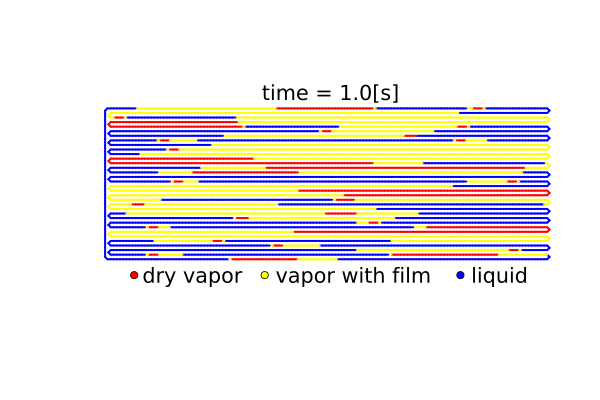

In [27]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    plot(OHPSlug(),i,SimuResult)
end

[ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/examples/tmp.gif


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/examples/tmp.gif")
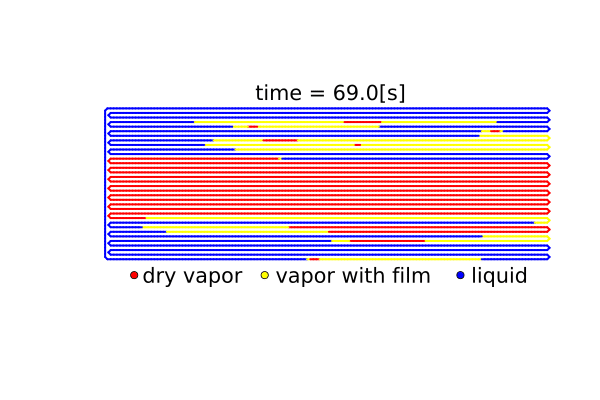

In [34]:
@gif for i in eachindex(SimuResult.tube_hist_t)[end:end]
    plot(OHPSlug(),i,SimuResult)
end